# Darcy Equation

## Preliminary steps

Import modules

In [2]:
%load_ext autoreload
%autoreload 2

import sys

module_dir = '../'

if module_dir not in sys.path:
    sys.path.append(module_dir)

import numpy as np
import matplotlib.pyplot as plt
import sklearn as skl
from models import *
import test_systems_1d as systems_1d
import itertools
from matplotlib.colors import TwoSlopeNorm
from matplotlib.colors import NoNorm
from matplotlib.colors import Normalize
from tqdm import tqdm
import gpjax as gpx
from sklearn.decomposition import PCA
import scipy.io
from scipy.interpolate import griddata

from jax import config
config.update("jax_enable_x64", True)

/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/cola/backends/backends.py:75: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


Train-test split

In [3]:
def get_data(filename, ndata, r):
    # 5->85x85, 6->71x71, 7->61x61, 10->43x43, 12->36x36, 14->31x31, 15->29x29 - basically r selects the course-grainedness, r=1 means no course-graining
    r = r
    s = int(((421 - 1) / r) + 1)

    # Data is of the shape (number of samples = 1024, grid size = 421x421)
    data = scipy.io.loadmat(filename)
    x_branch = data["coeff"][:ndata, ::r, ::r].astype(np.float32) * 0.1 - 0.75
    y = data["sol"][:ndata, ::r, ::r].astype(np.float32) * 100
    # The dataset has a mistake that the BC is not 0.
    y[:, 0, :] = 0
    y[:, -1, :] = 0
    y[:, :, 0] = 0
    y[:, :, -1] = 0

    grids = []
    grids.append(np.linspace(0, 1, s, dtype=np.float32))
    grids.append(np.linspace(0, 1, s, dtype=np.float32))
    grid = np.vstack([xx.ravel() for xx in np.meshgrid(*grids)]).T

    x_branch = x_branch.reshape(ndata, s * s)
    x = (x_branch, grid)
    y = y.reshape(ndata, s * s)
    return x[0], y, grid

r = 15
s = int(((421 - 1) / r) + 1)
print(s)

x_train, y_train, train_grid = get_data("../darcy_flow_data/rect_cont_PWC/piececonst_r421_N1024_smooth1.mat", 1000, r)
x_test, y_test, test_grid = get_data("../darcy_flow_data/rect_cont_PWC/piececonst_r421_N1024_smooth2.mat", 1000, r)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

29
(1000, 841) (1000, 841)
(1000, 841) (1000, 841)


visualise input/output data

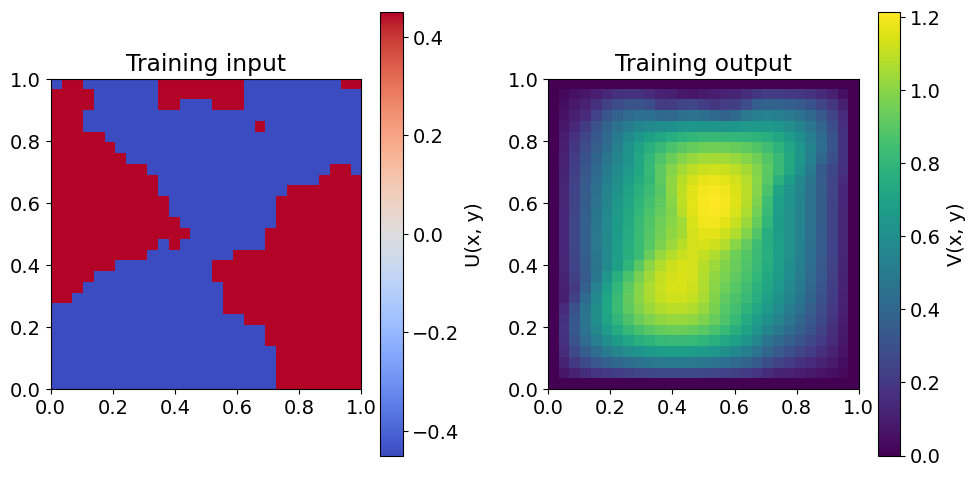

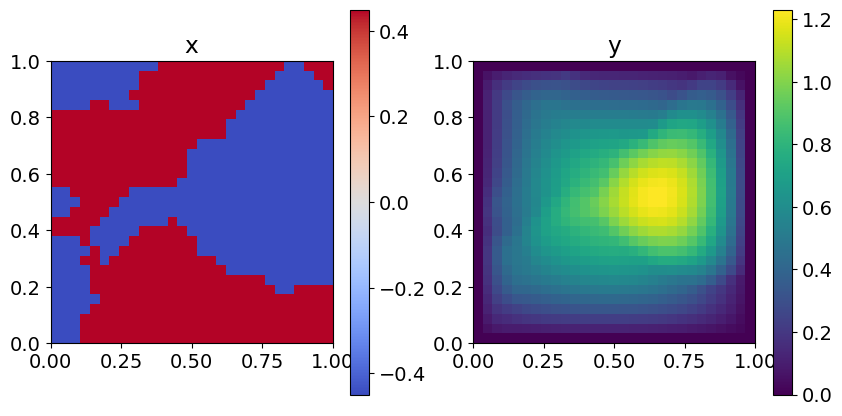

In [7]:
# rc params for line width, font sizes
plt.rcParams["lines.linewidth"] = 3
plt.rcParams["font.size"] = 14


index_to_plot = 127

# print(len(x_train), x_train.shape, x_train[1].shape, y_train.shape)
# print(len(x_test), x_test.shape, x_test[1].shape, y_test.shape)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
im0 = ax[0].imshow(x_train[index_to_plot, :].reshape(s, s), origin='lower', extent=[0, 1, 0, 1], cmap='coolwarm')
ax[0].set_title("Training input")
im1 = ax[1].imshow(y_train[index_to_plot, :].reshape(s, s), origin='lower', extent=[0, 1, 0, 1])
ax[1].set_title("Training output")
fig.colorbar(im0, ax=ax[0], label=r'U(x, y)')
fig.colorbar(im1, ax=ax[1], label=r'V(x, y)')
plt.tight_layout()
plt.savefig("../figures/darcy_training_data.pdf")
plt.show()

index_to_plot = 125

# print(len(x_train), x_train.shape, x_train[1].shape, y_train.shape)
# print(len(x_test), x_test.shape, x_test[1].shape, y_test.shape)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
im0 = ax[0].imshow(x_test[index_to_plot, :].reshape(s, s), origin='lower', extent=[0, 1, 0, 1], cmap='coolwarm')
ax[0].set_title("x")
im1 = ax[1].imshow(y_test[index_to_plot, :].reshape(s, s), origin='lower', extent=[0, 1, 0, 1])
ax[1].set_title("y")
fig.colorbar(im0, ax=ax[0])
fig.colorbar(im1, ax=ax[1])
plt.show()

## Model definition

In [4]:
import sys
module_dir = '../'
if module_dir not in sys.path:
    sys.path.append(module_dir)
from models import *
import gpjax as gpx

## determine `n` and `m`

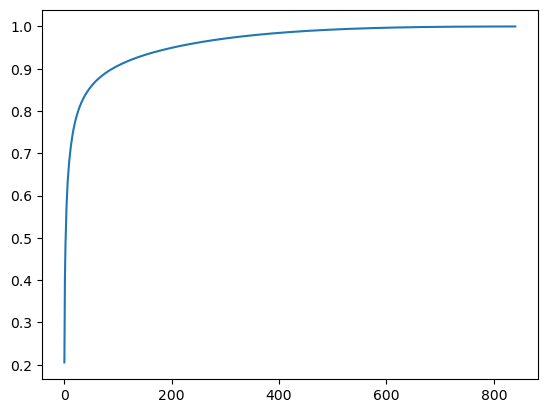

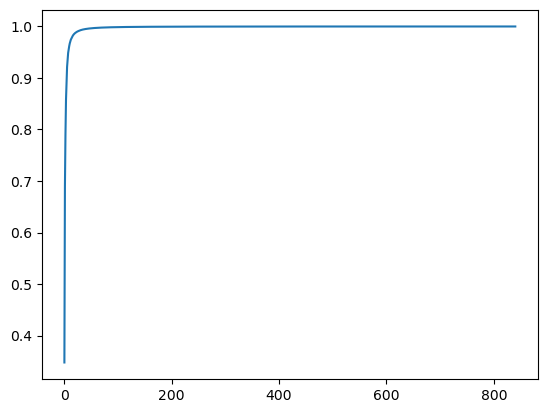

202 24


In [5]:
# determine n
x_pca = PCA(n_components=x_train.shape[-1])
x_train_pca = x_pca.fit_transform(x_train)

plt.plot(np.cumsum(x_pca.explained_variance_ratio_))
plt.show()

n = np.where(np.cumsum(x_pca.explained_variance_ratio_) > 0.95)[0][0]

# determine m
y_pca = PCA(n_components=y_train.shape[-1])
y_train_pca = y_pca.fit_transform(y_train)

plt.plot(np.cumsum(y_pca.explained_variance_ratio_))
plt.show()

m = np.where(np.cumsum(y_pca.explained_variance_ratio_) > 0.99)[0][0]

print(n, m)

## Train

In [18]:
n_samples = 6

model = full_model(n = 50, m = 50, ARD = False, multiinput = True, standardise = True, combine_pca = False)
train_samples = model.fit(x_train, y_train, n_samples = None)

does x pca
does y pca


  0%|          | 0/50 [00:00<?, ?it/s]

[1.]
float64


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
  2%|▏         | 1/50 [00:36<29:35, 36.22s/it]

         Current function value: -631.792136
         Iterations: 18
         Function evaluations: 63
         Gradient evaluations: 51
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([24.60172363], dtype=float64), variance=Array([6.94572433], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.001], dtype=float64))
[2.]
[1.]
[1.]
float64


  4%|▍         | 2/50 [00:54<20:35, 25.74s/it]

Optimization terminated successfully.
         Current function value: -638.719613
         Iterations: 20
         Function evaluations: 24
         Gradient evaluations: 24
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([25.17630423], dtype=float64), variance=Array([7.4941691], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.001], dtype=float64))
[2.]
[1.]
[1.]
float64


  6%|▌         | 3/50 [01:34<25:14, 32.23s/it]

Optimization terminated successfully.
         Current function value: 208.492599
         Iterations: 38
         Function evaluations: 57
         Gradient evaluations: 57
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([17.99693683], dtype=float64), variance=Array([8.19707473], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.09787186], dtype=float64))
[2.]
[1.]
[1.]
float64


  8%|▊         | 4/50 [02:29<31:26, 41.01s/it]

Optimization terminated successfully.
         Current function value: -3.291622
         Iterations: 60
         Function evaluations: 66
         Gradient evaluations: 66
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([18.01155282], dtype=float64), variance=Array([7.30021749], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.001], dtype=float64))
[2.]
[1.]
[1.]
float64


 10%|█         | 5/50 [03:14<31:51, 42.48s/it]

Optimization terminated successfully.
         Current function value: 218.165766
         Iterations: 55
         Function evaluations: 60
         Gradient evaluations: 60
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([16.03947298], dtype=float64), variance=Array([7.28780399], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.00100001], dtype=float64))
[2.]
[1.]
[1.]
float64


 12%|█▏        | 6/50 [03:46<28:32, 38.91s/it]

Optimization terminated successfully.
         Current function value: 135.845922
         Iterations: 34
         Function evaluations: 47
         Gradient evaluations: 47
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([16.86780297], dtype=float64), variance=Array([6.8924907], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.04612088], dtype=float64))
[2.]
[1.]
[1.]
float64


 14%|█▍        | 7/50 [04:16<25:57, 36.22s/it]

Optimization terminated successfully.
         Current function value: 264.085867
         Iterations: 31
         Function evaluations: 43
         Gradient evaluations: 43
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([16.0169163], dtype=float64), variance=Array([7.12881612], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.06091134], dtype=float64))
[2.]
[1.]
[1.]
float64


 16%|█▌        | 8/50 [04:53<25:32, 36.49s/it]

Optimization terminated successfully.
         Current function value: 320.402672
         Iterations: 39
         Function evaluations: 56
         Gradient evaluations: 56
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([15.62253861], dtype=float64), variance=Array([7.64600479], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.04586026], dtype=float64))
[2.]
[1.]
[1.]
float64


 18%|█▊        | 9/50 [05:22<23:19, 34.14s/it]

Optimization terminated successfully.
         Current function value: 539.337973
         Iterations: 32
         Function evaluations: 42
         Gradient evaluations: 42
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([12.15025102], dtype=float64), variance=Array([4.62412912], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.05962282], dtype=float64))
[2.]
[1.]
[1.]
float64


 20%|██        | 10/50 [05:57<22:46, 34.17s/it]

Optimization terminated successfully.
         Current function value: 598.731990
         Iterations: 36
         Function evaluations: 53
         Gradient evaluations: 53
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([12.55548687], dtype=float64), variance=Array([6.022589], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.04588241], dtype=float64))
[2.]
[1.]
[1.]
float64


 22%|██▏       | 11/50 [06:22<20:29, 31.53s/it]

Optimization terminated successfully.
         Current function value: 430.298313
         Iterations: 28
         Function evaluations: 36
         Gradient evaluations: 36
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([13.6050476], dtype=float64), variance=Array([5.47694866], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.06663799], dtype=float64))
[2.]
[1.]
[1.]
float64


 24%|██▍       | 12/50 [06:51<19:22, 30.60s/it]

Optimization terminated successfully.
         Current function value: 659.455869
         Iterations: 32
         Function evaluations: 37
         Gradient evaluations: 37
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([10.8788442], dtype=float64), variance=Array([4.08670091], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.0351339], dtype=float64))
[2.]
[1.]
[1.]
float64


 26%|██▌       | 13/50 [07:15<17:43, 28.75s/it]

Optimization terminated successfully.
         Current function value: 565.197963
         Iterations: 28
         Function evaluations: 33
         Gradient evaluations: 33
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([11.93299352], dtype=float64), variance=Array([4.5141673], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.06691277], dtype=float64))
[2.]
[1.]
[1.]
float64


 28%|██▊       | 14/50 [07:37<16:04, 26.80s/it]

Optimization terminated successfully.
         Current function value: 668.856164
         Iterations: 24
         Function evaluations: 31
         Gradient evaluations: 31
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([11.6343125], dtype=float64), variance=Array([4.72946442], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.10954491], dtype=float64))
[2.]
[1.]
[1.]
float64


 30%|███       | 15/50 [07:57<14:18, 24.53s/it]

Optimization terminated successfully.
         Current function value: 738.816935
         Iterations: 21
         Function evaluations: 26
         Gradient evaluations: 26
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([9.81858828], dtype=float64), variance=Array([2.91078496], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.13183915], dtype=float64))
[2.]
[1.]
[1.]
float64


 32%|███▏      | 16/50 [08:20<13:39, 24.10s/it]

Optimization terminated successfully.
         Current function value: 702.024635
         Iterations: 26
         Function evaluations: 31
         Gradient evaluations: 31
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([10.19000158], dtype=float64), variance=Array([3.29991274], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.09115813], dtype=float64))
[2.]
[1.]
[1.]
float64


 34%|███▍      | 17/50 [08:40<12:41, 23.08s/it]

Optimization terminated successfully.
         Current function value: 686.044614
         Iterations: 23
         Function evaluations: 28
         Gradient evaluations: 28
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([10.68380982], dtype=float64), variance=Array([3.42204654], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.13498049], dtype=float64))
[2.]
[1.]
[1.]
float64


 36%|███▌      | 18/50 [09:04<12:18, 23.07s/it]

Optimization terminated successfully.
         Current function value: 795.457167
         Iterations: 24
         Function evaluations: 31
         Gradient evaluations: 31
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([10.38307724], dtype=float64), variance=Array([4.05698672], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.12648961], dtype=float64))
[2.]
[1.]
[1.]
float64


 38%|███▊      | 19/50 [09:25<11:40, 22.59s/it]

Optimization terminated successfully.
         Current function value: 782.309946
         Iterations: 23
         Function evaluations: 28
         Gradient evaluations: 28
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([10.10839129], dtype=float64), variance=Array([3.42264914], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.14898167], dtype=float64))
[2.]
[1.]
[1.]
float64


 40%|████      | 20/50 [09:44<10:49, 21.65s/it]

Optimization terminated successfully.
         Current function value: 774.497256
         Iterations: 21
         Function evaluations: 26
         Gradient evaluations: 26
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([9.66360238], dtype=float64), variance=Array([2.64618167], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.18315552], dtype=float64))
[2.]
[1.]
[1.]
float64


 42%|████▏     | 21/50 [10:03<10:05, 20.86s/it]

Optimization terminated successfully.
         Current function value: 834.362004
         Iterations: 21
         Function evaluations: 26
         Gradient evaluations: 26
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([10.44204574], dtype=float64), variance=Array([3.19341651], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.25596065], dtype=float64))
[2.]
[1.]
[1.]
float64


 44%|████▍     | 22/50 [10:21<09:19, 19.99s/it]

Optimization terminated successfully.
         Current function value: 926.261271
         Iterations: 19
         Function evaluations: 25
         Gradient evaluations: 25
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([9.90841937], dtype=float64), variance=Array([3.38310777], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.26534608], dtype=float64))
[2.]
[1.]
[1.]
float64


 46%|████▌     | 23/50 [10:44<09:20, 20.75s/it]

Optimization terminated successfully.
         Current function value: 951.742821
         Iterations: 23
         Function evaluations: 29
         Gradient evaluations: 29
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([8.34303273], dtype=float64), variance=Array([2.33813888], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.21924694], dtype=float64))
[2.]
[1.]
[1.]
float64


 48%|████▊     | 24/50 [11:03<08:48, 20.31s/it]

Optimization terminated successfully.
         Current function value: 954.200954
         Iterations: 20
         Function evaluations: 26
         Gradient evaluations: 26
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([8.13383897], dtype=float64), variance=Array([2.28777208], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.19351563], dtype=float64))
[2.]
[1.]
[1.]
float64


 50%|█████     | 25/50 [11:21<08:10, 19.62s/it]

Optimization terminated successfully.
         Current function value: 997.941563
         Iterations: 19
         Function evaluations: 25
         Gradient evaluations: 25
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([8.85798039], dtype=float64), variance=Array([2.63910779], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.29526987], dtype=float64))
[2.]
[1.]
[1.]
float64


 52%|█████▏    | 26/50 [11:40<07:43, 19.29s/it]

Optimization terminated successfully.
         Current function value: 943.449038
         Iterations: 19
         Function evaluations: 26
         Gradient evaluations: 26
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([8.55287001], dtype=float64), variance=Array([2.53246709], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.20917381], dtype=float64))
[2.]
[1.]
[1.]
float64


 54%|█████▍    | 27/50 [11:59<07:22, 19.26s/it]

Optimization terminated successfully.
         Current function value: 1065.768510
         Iterations: 20
         Function evaluations: 24
         Gradient evaluations: 24
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([7.27799908], dtype=float64), variance=Array([1.81401169], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.28099741], dtype=float64))
[2.]
[1.]
[1.]
float64


 56%|█████▌    | 28/50 [12:19<07:11, 19.62s/it]

Optimization terminated successfully.
         Current function value: 1103.514475
         Iterations: 18
         Function evaluations: 24
         Gradient evaluations: 24
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([7.49644206], dtype=float64), variance=Array([2.15704751], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.28579719], dtype=float64))
[2.]
[1.]
[1.]
float64


 58%|█████▊    | 29/50 [12:42<07:07, 20.36s/it]

Optimization terminated successfully.
         Current function value: 1087.441480
         Iterations: 22
         Function evaluations: 28
         Gradient evaluations: 28
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([7.63941282], dtype=float64), variance=Array([2.17864584], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.28773998], dtype=float64))
[2.]
[1.]
[1.]
float64


 60%|██████    | 30/50 [12:59<06:30, 19.55s/it]

Optimization terminated successfully.
         Current function value: 1111.844954
         Iterations: 18
         Function evaluations: 23
         Gradient evaluations: 23
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([7.21713798], dtype=float64), variance=Array([1.96427302], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.28846728], dtype=float64))
[2.]
[1.]
[1.]
float64


 62%|██████▏   | 31/50 [13:15<05:53, 18.59s/it]

Optimization terminated successfully.
         Current function value: 1158.961764
         Iterations: 17
         Function evaluations: 22
         Gradient evaluations: 22
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([6.46779916], dtype=float64), variance=Array([1.61861891], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.29553114], dtype=float64))
[2.]
[1.]
[1.]
float64


 64%|██████▍   | 32/50 [13:33<05:31, 18.39s/it]

Optimization terminated successfully.
         Current function value: 1187.609235
         Iterations: 19
         Function evaluations: 25
         Gradient evaluations: 25
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([6.75948647], dtype=float64), variance=Array([1.5797926], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.4013052], dtype=float64))
[2.]
[1.]
[1.]
float64


 66%|██████▌   | 33/50 [13:51<05:10, 18.24s/it]

Optimization terminated successfully.
         Current function value: 1083.179898
         Iterations: 18
         Function evaluations: 26
         Gradient evaluations: 26
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([7.94264819], dtype=float64), variance=Array([2.14043521], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.33884753], dtype=float64))
[2.]
[1.]
[1.]
float64


 68%|██████▊   | 34/50 [14:12<05:05, 19.09s/it]

Optimization terminated successfully.
         Current function value: 1057.380152
         Iterations: 21
         Function evaluations: 27
         Gradient evaluations: 27
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([8.6515074], dtype=float64), variance=Array([2.40547684], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.36061311], dtype=float64))
[2.]
[1.]
[1.]
float64


 70%|███████   | 35/50 [14:30<04:41, 18.73s/it]

Optimization terminated successfully.
         Current function value: 1178.251498
         Iterations: 18
         Function evaluations: 25
         Gradient evaluations: 25
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([6.7410874], dtype=float64), variance=Array([1.73067234], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.34517806], dtype=float64))
[2.]
[1.]
[1.]
float64


 72%|███████▏  | 36/50 [14:51<04:30, 19.32s/it]

Optimization terminated successfully.
         Current function value: 1237.637119
         Iterations: 21
         Function evaluations: 29
         Gradient evaluations: 29
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([5.96207], dtype=float64), variance=Array([1.46028194], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.3543821], dtype=float64))
[2.]
[1.]
[1.]
float64


 74%|███████▍  | 37/50 [15:11<04:14, 19.58s/it]

Optimization terminated successfully.
         Current function value: 1281.275988
         Iterations: 20
         Function evaluations: 28
         Gradient evaluations: 28
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([5.73397078], dtype=float64), variance=Array([1.30872658], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.4297093], dtype=float64))
[2.]
[1.]
[1.]
float64


 76%|███████▌  | 38/50 [15:29<03:47, 18.93s/it]

Optimization terminated successfully.
         Current function value: 1244.135663
         Iterations: 18
         Function evaluations: 26
         Gradient evaluations: 26
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([6.00100324], dtype=float64), variance=Array([1.39459025], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.39719861], dtype=float64))
[2.]
[1.]
[1.]
float64


 78%|███████▊  | 39/50 [15:49<03:32, 19.28s/it]

Optimization terminated successfully.
         Current function value: 1278.085597
         Iterations: 22
         Function evaluations: 29
         Gradient evaluations: 29
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([5.96066211], dtype=float64), variance=Array([1.41073745], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.43148247], dtype=float64))
[2.]
[1.]
[1.]
float64


 80%|████████  | 40/50 [16:10<03:18, 19.87s/it]

Optimization terminated successfully.
         Current function value: 1237.883919
         Iterations: 22
         Function evaluations: 30
         Gradient evaluations: 30
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([6.17775716], dtype=float64), variance=Array([1.61146947], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.34753576], dtype=float64))
[2.]
[1.]
[1.]
float64


 82%|████████▏ | 41/50 [16:27<02:52, 19.13s/it]

Optimization terminated successfully.
         Current function value: 1273.194209
         Iterations: 20
         Function evaluations: 24
         Gradient evaluations: 24
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([5.7944654], dtype=float64), variance=Array([1.40553681], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.39229045], dtype=float64))
[2.]
[1.]
[1.]
float64


 84%|████████▍ | 42/50 [16:46<02:33, 19.13s/it]

Optimization terminated successfully.
         Current function value: 1222.172184
         Iterations: 20
         Function evaluations: 27
         Gradient evaluations: 27
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([6.2962085], dtype=float64), variance=Array([1.52436909], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.38029137], dtype=float64))
[2.]
[1.]
[1.]
float64


 86%|████████▌ | 43/50 [17:09<02:21, 20.26s/it]

Optimization terminated successfully.
         Current function value: 1257.638916
         Iterations: 23
         Function evaluations: 32
         Gradient evaluations: 32
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([6.393911], dtype=float64), variance=Array([1.4843761], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.4564216], dtype=float64))
[2.]
[1.]
[1.]
float64


 88%|████████▊ | 44/50 [17:29<02:01, 20.18s/it]

Optimization terminated successfully.
         Current function value: 1249.320911
         Iterations: 19
         Function evaluations: 27
         Gradient evaluations: 27
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([6.17639525], dtype=float64), variance=Array([1.2999789], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.46575858], dtype=float64))
[2.]
[1.]
[1.]
float64


 90%|█████████ | 45/50 [17:53<01:45, 21.08s/it]

Optimization terminated successfully.
         Current function value: 1307.155050
         Iterations: 22
         Function evaluations: 31
         Gradient evaluations: 31
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([5.08938946], dtype=float64), variance=Array([1.21025291], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.37106777], dtype=float64))
[2.]
[1.]
[1.]
float64


 92%|█████████▏| 46/50 [18:13<01:24, 21.04s/it]

Optimization terminated successfully.
         Current function value: 1275.624882
         Iterations: 22
         Function evaluations: 30
         Gradient evaluations: 30
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([6.70313526], dtype=float64), variance=Array([1.50495553], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.51741305], dtype=float64))
[2.]
[1.]
[1.]
float64


 94%|█████████▍| 47/50 [18:30<00:59, 19.83s/it]

Optimization terminated successfully.
         Current function value: 1306.275650
         Iterations: 18
         Function evaluations: 24
         Gradient evaluations: 24
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([5.21570822], dtype=float64), variance=Array([1.16688382], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.42285299], dtype=float64))
[2.]
[1.]
[1.]
float64


 96%|█████████▌| 48/50 [18:50<00:39, 19.86s/it]

Optimization terminated successfully.
         Current function value: 1299.333390
         Iterations: 21
         Function evaluations: 30
         Gradient evaluations: 30
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([5.61697304], dtype=float64), variance=Array([1.17912068], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.48338743], dtype=float64))
[2.]
[1.]
[1.]
float64


 98%|█████████▊| 49/50 [19:09<00:19, 19.44s/it]

Optimization terminated successfully.
         Current function value: 1345.285021
         Iterations: 21
         Function evaluations: 26
         Gradient evaluations: 26
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([5.00619794], dtype=float64), variance=Array([1.08033604], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.48402829], dtype=float64))
[2.]
[1.]
[1.]
float64


100%|██████████| 50/50 [19:27<00:00, 23.36s/it]

Optimization terminated successfully.
         Current function value: 1343.490396
         Iterations: 21
         Function evaluations: 26
         Gradient evaluations: 26
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([4.69885261], dtype=float64), variance=Array([1.23669746], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.30532589], dtype=float64))
[2.]
[1.]


## Assess performance on training data

In [19]:
n_samples = 6

y_pred_train, train_samples = model.predict(x_train, n_samples = n_samples)

print(train_samples.shape)

relative_L2 = np.linalg.norm(y_pred_train - y_train, axis = -1)/np.linalg.norm(y_train, axis = -1)

print(f'median relative L2 (train data): {np.median(relative_L2)}')
print(f'mean relative L2 (train data): {np.mean(relative_L2)}')

100%|██████████| 50/50 [01:37<00:00,  1.95s/it]


(1000, 841, 6)
median relative L2 (train data): 0.016239561270088347
mean relative L2 (train data): 0.01617940915501931


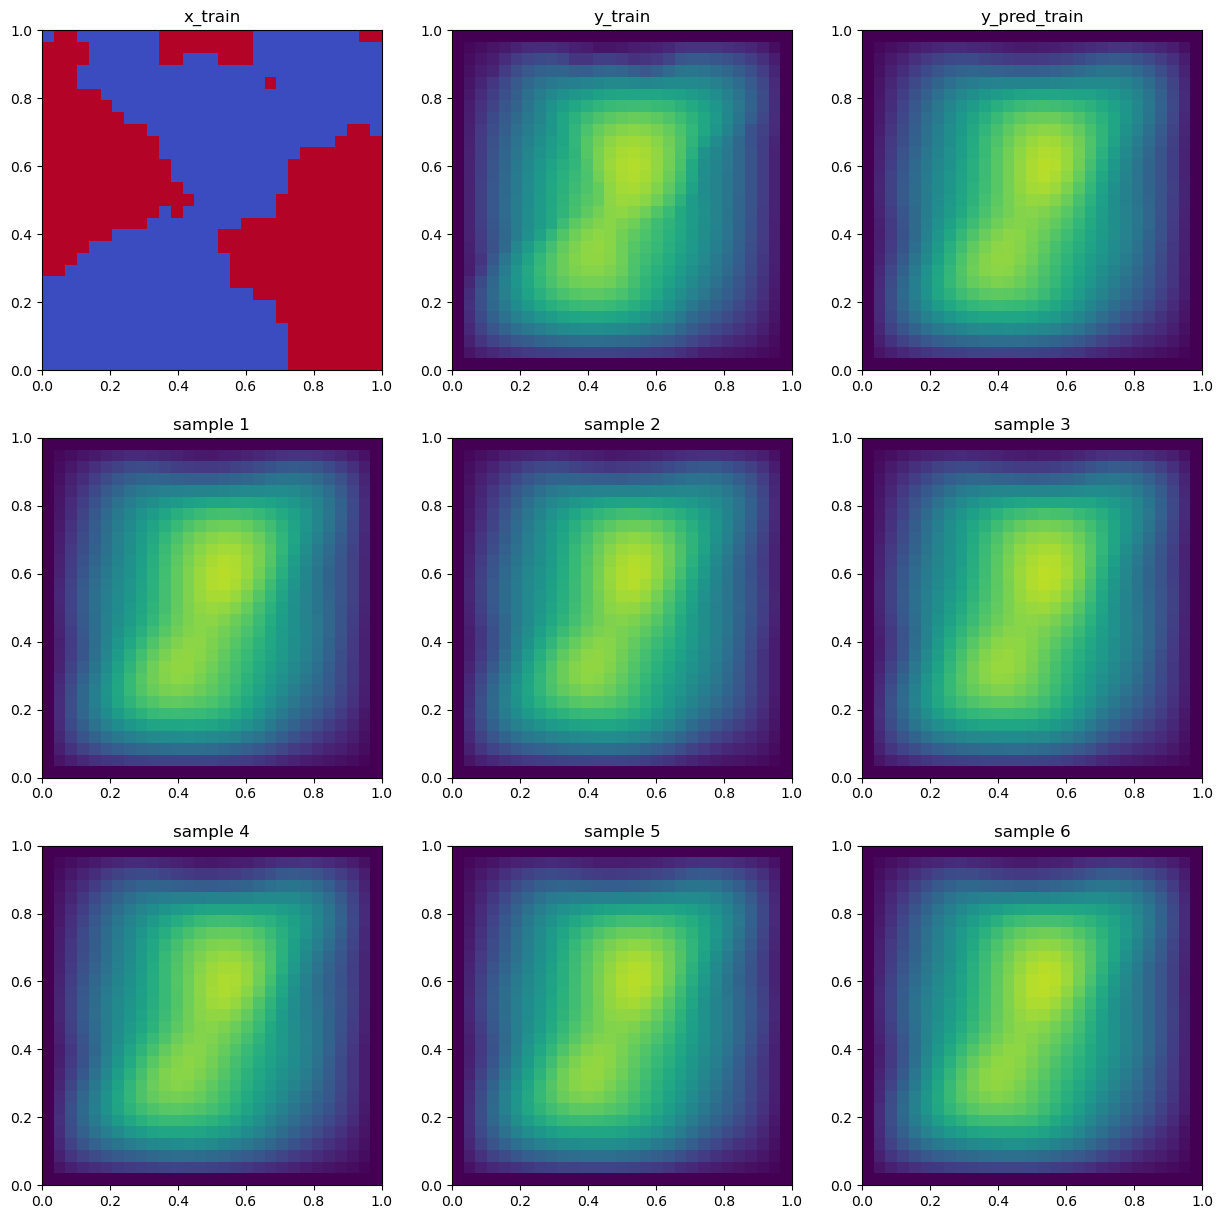

In [20]:
index_to_plot = 127

y_lims = np.array([min(y_test[index_to_plot, :].min(), y_pred_train[index_to_plot, :].min()), max(y_test[index_to_plot, :].max(), y_pred_train[index_to_plot, :].max())])

fig, ax = plt.subplots(3, 3, figsize = (15, 15))
ax = ax.flatten()
im0 = ax[0].imshow(x_train[index_to_plot, :].reshape(s, s), origin='lower', extent=[0, 1, 0, 1], cmap='coolwarm')
ax[0].set_title("x_train")
im1 = ax[1].imshow(y_train[index_to_plot, :].reshape(s, s), origin='lower', extent=[0, 1, 0, 1], norm=Normalize(vmin=y_lims[0], vmax=y_lims[1]))
ax[1].set_title("y_train")
im2 = ax[2].imshow(y_pred_train[index_to_plot, :].reshape(s, s), origin='lower', extent=[0, 1, 0, 1], norm=Normalize(vmin=y_lims[0], vmax=y_lims[1]))
ax[2].set_title("y_pred_train")
for i in range(6):
    imi = ax[i+3].imshow(train_samples[index_to_plot, :, i].reshape(s, s), origin='lower', extent=[0, 1, 0, 1], norm=Normalize(vmin=y_lims[0], vmax=y_lims[1]))
    ax[i+3].set_title(f"sample {i+1}")
    
            # ax[i].legend()
plt.show()

## Test

In [21]:
n_samples = 100

y_pred_test, test_samples = model.predict(x_test, n_samples = n_samples)

relative_L2 = np.linalg.norm(y_pred_test - y_test, axis = -1)/np.linalg.norm(y_test, axis = -1)

print(f'median relative L2: {np.median(relative_L2)}')
print(f'mean relative L2: {np.mean(relative_L2)}')

100%|██████████| 50/50 [01:37<00:00,  1.94s/it]


median relative L2: 0.03947510184973183
mean relative L2: 0.0409500254713922


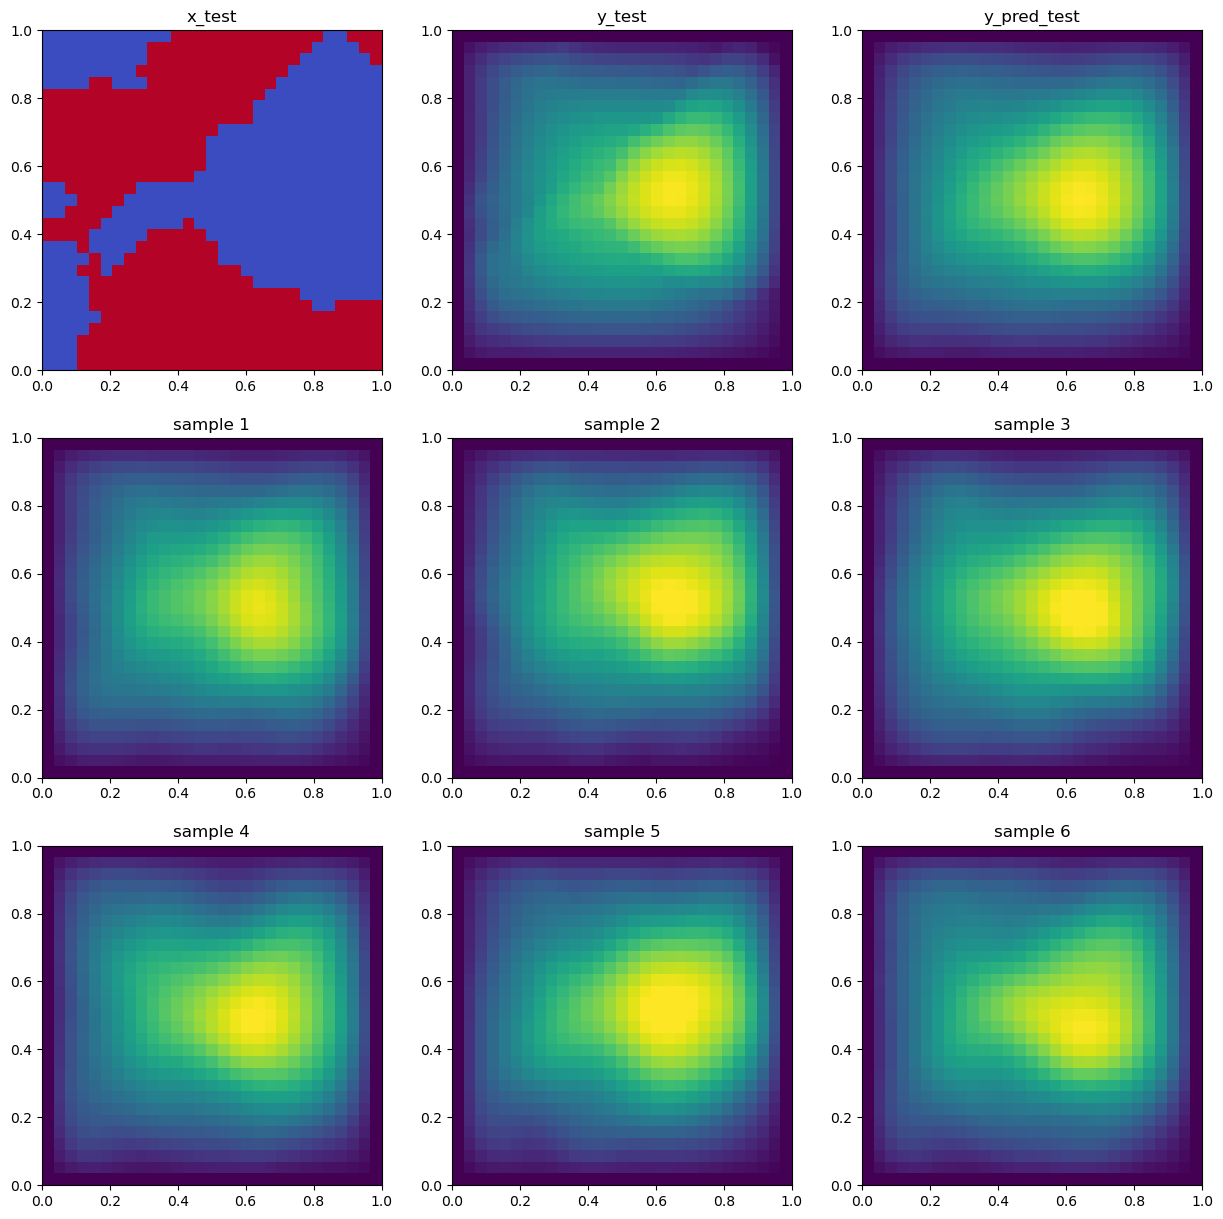

In [22]:
index_to_plot = 125

y_lims = np.array([min(y_test[index_to_plot, :].min(), y_pred_test[index_to_plot, :].min()), max(y_test[index_to_plot, :].max(), y_pred_test[index_to_plot, :].max())])

fig, ax = plt.subplots(3, 3, figsize = (15, 15))
ax = ax.flatten()
im0 = ax[0].imshow(x_test[index_to_plot, :].reshape(s, s), origin='lower', extent=[0, 1, 0, 1], cmap='coolwarm')
ax[0].set_title("x_test")
im1 = ax[1].imshow(y_test[index_to_plot, :].reshape(s, s), origin='lower', extent=[0, 1, 0, 1], norm=Normalize(vmin=y_lims[0], vmax=y_lims[1]))
ax[1].set_title("y_test")
im2 = ax[2].imshow(y_pred_test[index_to_plot, :].reshape(s, s), origin='lower', extent=[0, 1, 0, 1], norm=Normalize(vmin=y_lims[0], vmax=y_lims[1]))
ax[2].set_title("y_pred_test")
for i in range(6):
    imi = ax[i+3].imshow(test_samples[index_to_plot, :, i].reshape(s, s), origin='lower', extent=[0, 1, 0, 1], norm=Normalize(vmin=y_lims[0], vmax=y_lims[1]))
    ax[i+3].set_title(f"sample {i+1}")
    
            # ax[i].legend()
plt.show()

## analyse uncertainty

In [23]:
print(test_samples.shape)

test_samples_mean = np.mean(test_samples, axis = 2)
test_samples_std = np.std(test_samples, axis = 2)

(1000, 841, 100)


In [4]:
index_to_plot = 125

y_lims = np.array([min(y_test[index_to_plot, :].min(), test_samples_mean[index_to_plot, :].min()), max(y_test[index_to_plot, :].max(), test_samples_mean[index_to_plot, :].max())])

fig, ax = plt.subplots(2, 2, figsize = (10, 10))
ax = ax.flatten()

im0 = ax[0].imshow(x_test[index_to_plot, :].reshape(s, s), origin='lower', extent=[0, 1, 0, 1], cmap='coolwarm')
ax[0].set_title("x_test")
im1 = ax[1].imshow(y_test[index_to_plot, :].reshape(s, s), origin='lower', extent=[0, 1, 0, 1], norm=Normalize(vmin=y_lims[0], vmax=y_lims[1]))
ax[1].set_title("y_test")
im2 = ax[2].imshow(test_samples_mean[index_to_plot, :].reshape(s, s), origin='lower', extent=[0, 1, 0, 1], norm=Normalize(vmin=y_lims[0], vmax=y_lims[1]))
ax[2].set_title(f"mean of {n_samples} test samples")
im3 = ax[3].imshow(test_samples_std[index_to_plot, :].reshape(s, s), origin='lower', extent=[0, 1, 0, 1])
ax[3].set_title(f"std of {n_samples} test samples")
fig.colorbar(im1, ax=ax[1])
fig.colorbar(im2, ax=ax[2])
fig.colorbar(im3, ax=ax[3])


NameError: name 'test_samples_mean' is not defined